In [191]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import pickle
from Bio.Seq import Seq
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, to_hex

# DMS data

Single mutant scores

In [192]:
dms_df = pd.read_csv("../results/final_variant_scores/final_variant_scores.csv", dtype=dict(position_IMTG=pd.Int16Dtype()))
# remove linker sites
dms_df = dms_df[dms_df.chain != "link"]
# add indicator for wildtype data
dms_df["WT"] = dms_df.wildtype == dms_df.mutant
# site string combinging chain and position
dms_df["site"] = [f"{chain}-{pos}" for chain, pos in zip(dms_df.chain, dms_df.position_IMTG)]
dms_df

,target,wildtype,position,position_IMTG,chain,mutant,mutation,codon,single_nt,bind,...,expr,delta_expr,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr,WT,site
0,CGG_naive,E,1,1,H,A,E1(H)A,GAG,True,10.48829,...,10.44614,-0.00453,19.0,2.0,6.78608,-0.07452,17.0,2.0,False,H-1
1,CGG_naive,E,1,1,H,C,E1(H)C,GAG,False,10.44477,...,10.32364,-0.12703,20.0,2.0,7.44234,0.58174,17.0,2.0,False,H-1
2,CGG_naive,E,1,1,H,D,E1(H)D,GAG,True,10.42771,...,10.51618,0.06551,16.0,2.0,6.95940,0.09880,13.0,2.0,False,H-1
3,CGG_naive,E,1,1,H,E,E1(H)E,GAG,True,10.45719,...,10.45067,0.00000,21170.0,2.0,6.86060,0.00000,18910.0,2.0,True,H-1
4,CGG_naive,E,1,1,H,F,E1(H)F,GAG,False,10.51899,...,10.33163,-0.11904,24.0,2.0,6.91372,0.05313,21.0,2.0,False,H-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4695,CGG_naive,R,235,124,L,S,R124(L)S,CGT,True,10.44756,...,10.54313,0.09246,39.0,2.0,6.93925,0.07866,33.0,2.0,False,L-124
4696,CGG_naive,R,235,124,L,T,R124(L)T,CGT,False,10.43023,...,10.53860,0.08793,36.0,2.0,6.88956,0.02896,34.0,2.0,False,L-124
4697,CGG_naive,R,235,124,L,V,R124(L)V,CGT,False,10.38231,...,10.48707,0.03640,27.0,2.0,6.78160,-0.07899,24.0,2.0,False,L-124
4698,CGG_naive,R,235,124,L,W,R124(L)W,CGT,False,10.48219,...,10.38698,-0.06369,33.0,2.0,6.91474,0.05415,29.0,2.0,False,L-124


Position maps for scFv

In [193]:
pos_df = pd.read_csv("../data/CGGnaive_sites.csv", dtype=dict(site=pd.Int16Dtype()))
# remove linker sites
pos_df = pos_df[pos_df.chain != "link"]
pos_df

,site_scFv,amino_acid,chain,site,KI_codon
0,1,E,H,1,GAG
1,2,V,H,2,GTG
2,3,Q,H,3,CAG
3,4,L,H,4,CTT
4,5,Q,H,5,CAG
...,...,...,...,...,...
230,231,L,L,120,CTA
231,232,E,L,121,GAA
232,233,I,L,122,ATA
233,234,K,L,123,AAA


In [194]:
igh_pos_map = pos_df[pos_df.chain == "H"]
igk_pos_map = pos_df[pos_df.chain == "L"].reset_index(drop=True)

## Heatmaps indicating inaccessible first-step mutations

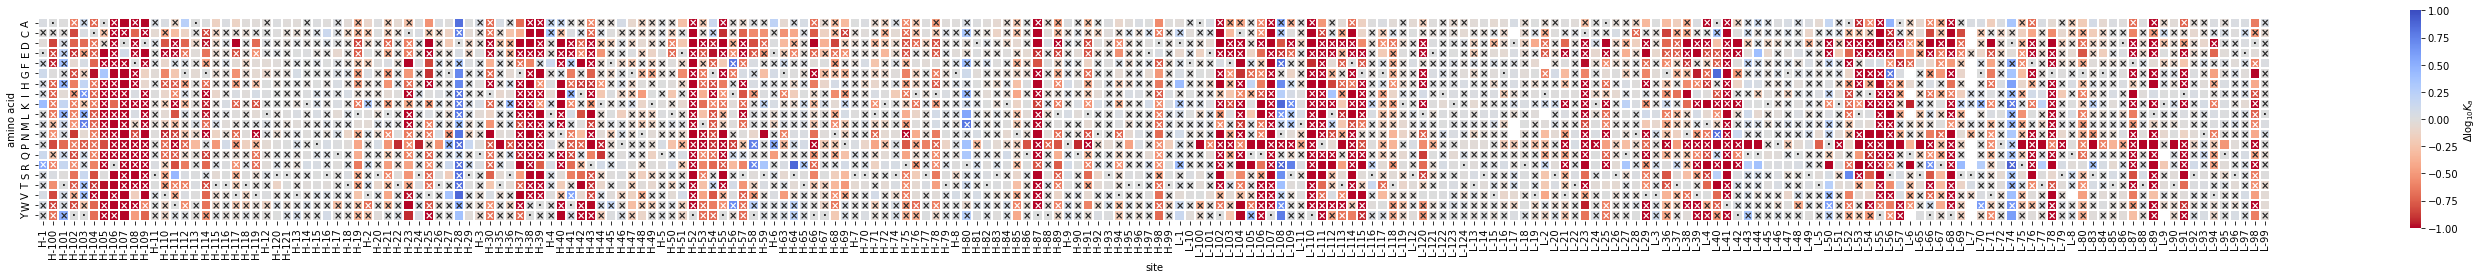

In [195]:
bind_df = dms_df.pivot(index="mutant", columns="site", values="delta_bind")

accessible_df = dms_df.pivot(index="mutant", columns="site", values="single_nt")
wt_df = dms_df.pivot(index="mutant", columns="site", values="WT")

annot = pd.DataFrame(np.empty_like(bind_df, dtype=str), index=bind_df.index, columns=bind_df.columns)
annot.iloc[wt_df.values.astype(bool)] = "\u00B7"
annot.iloc[~accessible_df.values.astype(bool)] = "\u00D7"

vmin = -1
vmax = 1

plt.figure(figsize=(50, 4))
sns.heatmap(bind_df, center=0, vmin=vmin, vmax=vmax, annot=annot, fmt="", annot_kws=dict(fontweight="bold"),
            cmap="coolwarm_r", cbar_kws=dict(label=r"$\Delta\log_{10} K_a$"), linewidths=.1, square=True)
plt.xlabel("site")
plt.ylabel("amino acid")
plt.show()

## Null distributions of sitewise first-step mutation effects
By "null" we mean uniform over states accesible with one nt mutation. We will later want to incorporate mutability weights (e.g. S5F)

**This is wrong! Need to count nucleotide-wise, and account for codon table**

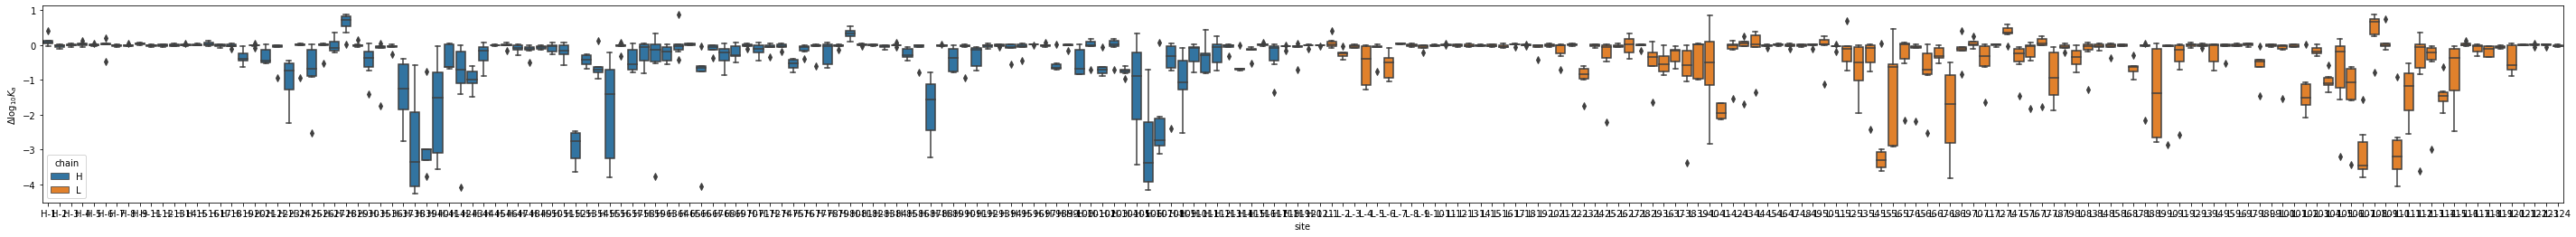

In [196]:
plt.figure(figsize=(50, 4))
sns.boxplot(data=dms_df[(~dms_df.WT) & dms_df.single_nt], x="site", y="delta_bind", hue="chain", dodge=False)
plt.ylabel(r"$\Delta\log_{10} K_a$")
plt.show()

# Replay tree data

In [5]:
trees = [pickle.load(open(f, "rb")) for f in glob.glob("*/*/gctree.out.inference.1.p")]

In [14]:
igh_frame = 1
igk_frame = 1
igk_idx = 336

## Functions for color mapping $\Delta\log K_a$ on trees

- Warm colors indicate $\Delta\log_{10} K_a < 0$
- Cool colors indicate $\Delta\log_{10} K_a > 0$

In [187]:
def aa(seq, frame):
    return Seq(seq[(frame - 1) : (frame - 1 + (3 * ((len(seq) - (frame - 1)) // 3)))]).translate()

def mutations(naive_aa, aa, pos_map, chain_annotation):
    return [f"{aa1}{pos_map[pos]}{chain_annotation}{aa2}"
            for pos, (aa1, aa2) in enumerate(zip(naive_aa, aa))
            if aa1 != aa2]

def bind_colormap(tree, vmin, vmax):
    naive_igh_aa = aa(tree.tree.sequence[:igk_idx], igh_frame)
    naive_igk_aa = aa(tree.tree.sequence[igk_idx:], igk_frame)

    cmap = cm.get_cmap("coolwarm_r")
    norm = Normalize(vmin=vmin, vmax=vmax)
    
    colormap = {}

    for node in tree.tree.traverse():
        igh_aa = aa(node.sequence[:igk_idx], igh_frame)
        igk_aa = aa(node.sequence[igk_idx:], igk_frame)
        igh_mutations = mutations(naive_igh_aa, igh_aa, igh_pos_map.site, "(H)")
        igk_mutations = mutations(naive_igk_aa, igk_aa, igk_pos_map.site, "(L)")

        sum_delta_bind = dms_df.delta_bind[dms_df.mutation.isin(igh_mutations + igk_mutations)].sum()

        colormap[node.name] = to_hex(cmap(norm(sum_delta_bind)))

    return colormap

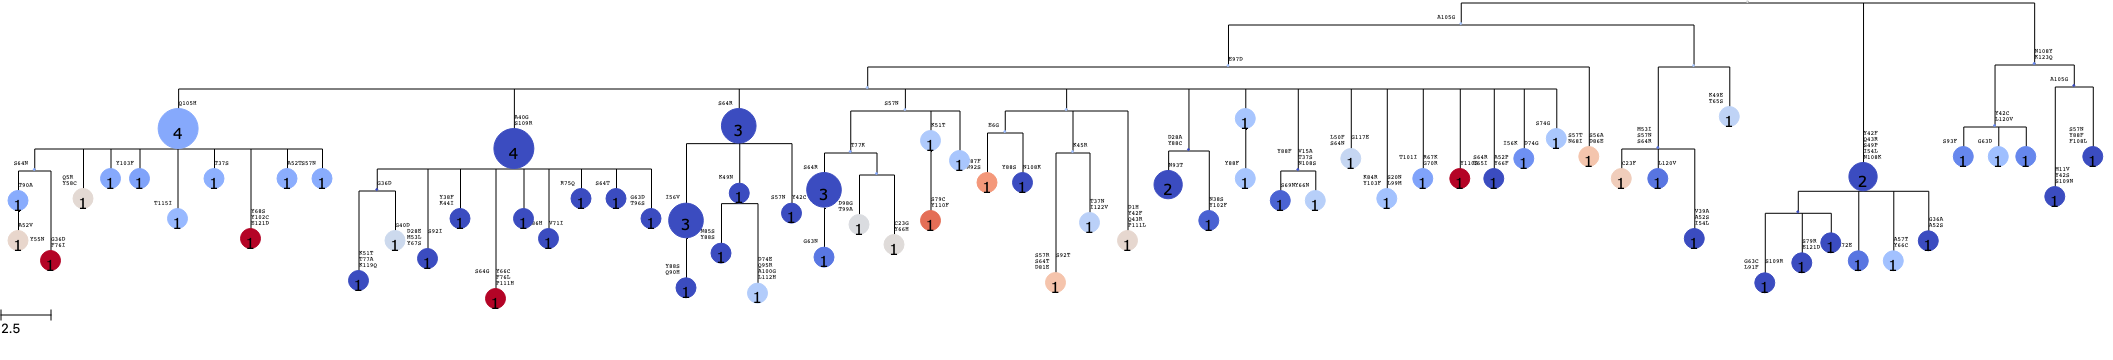

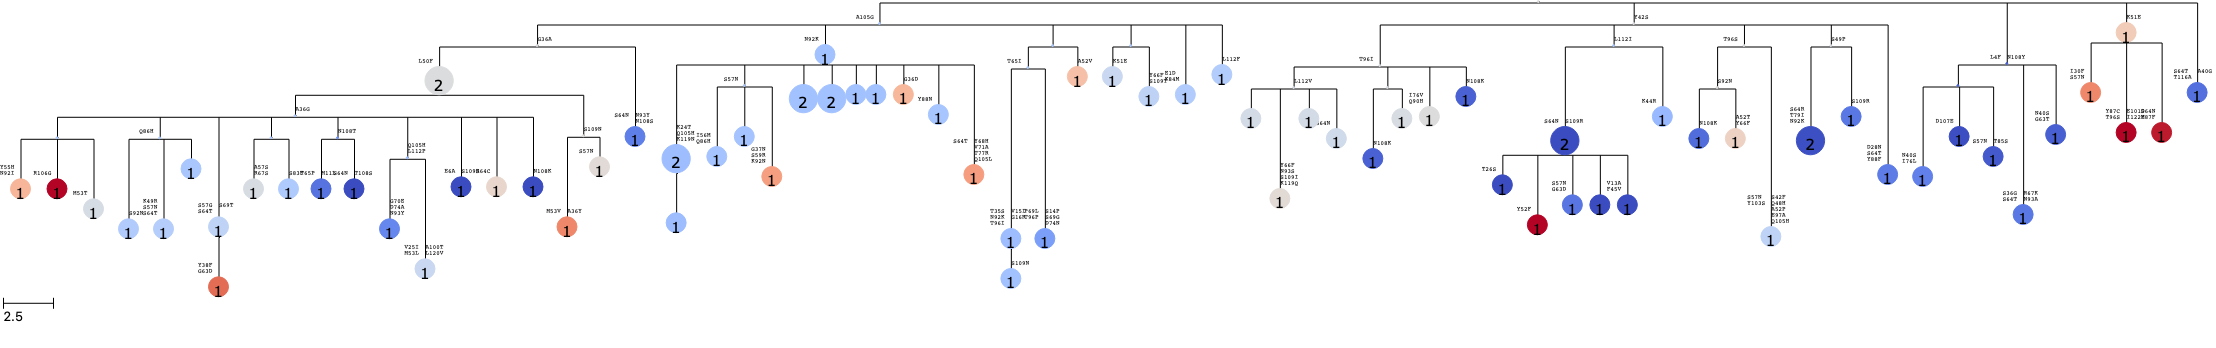

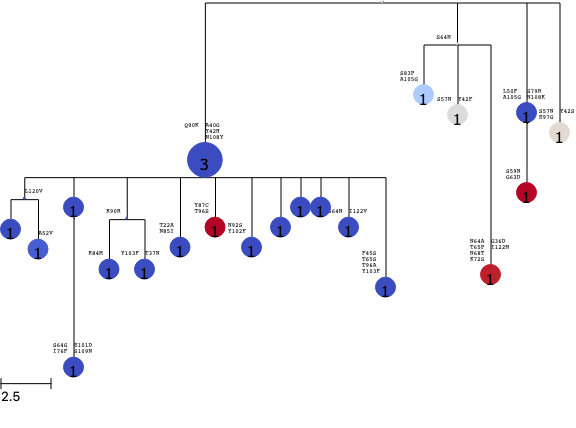

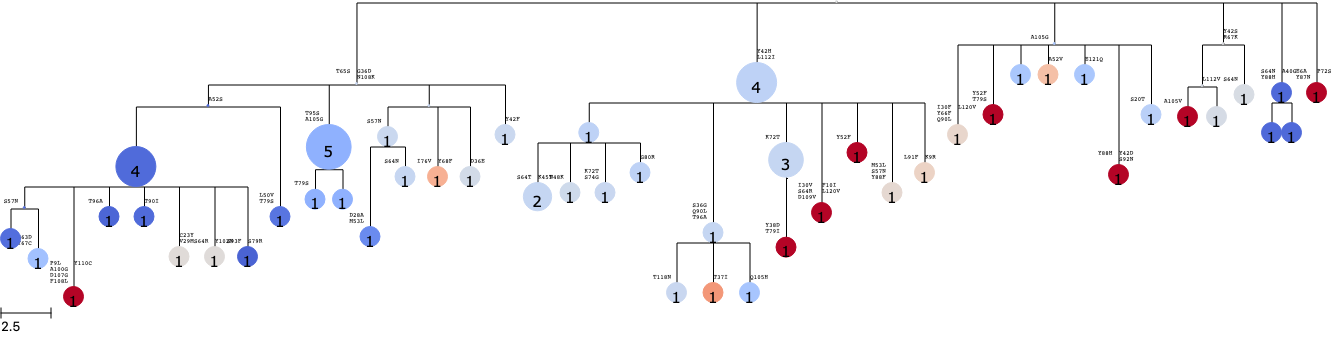

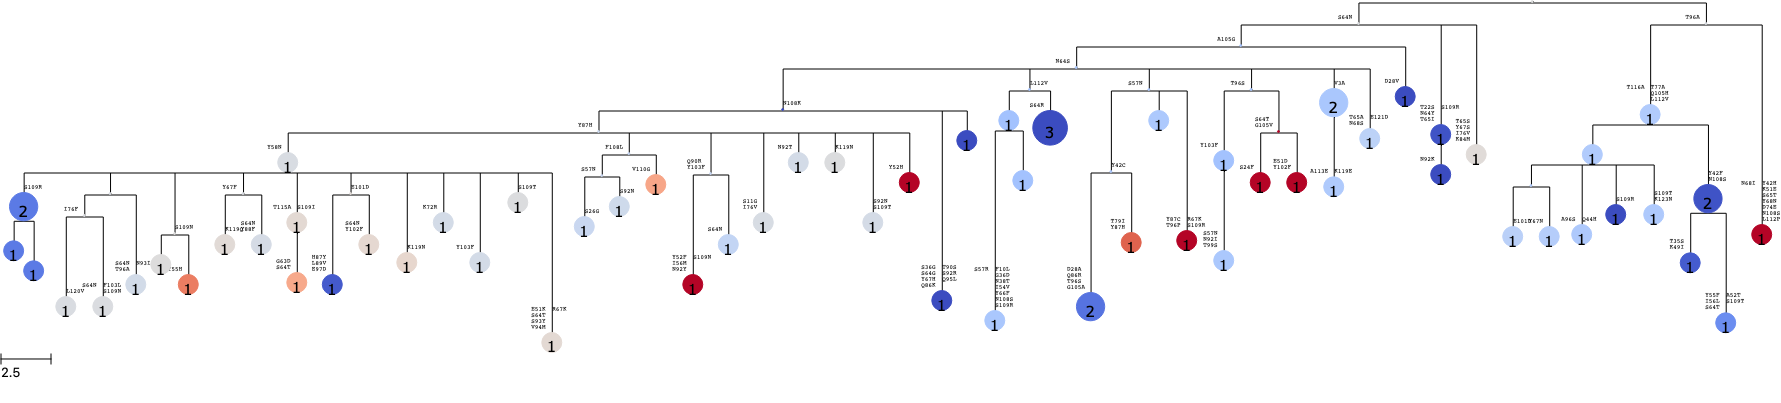

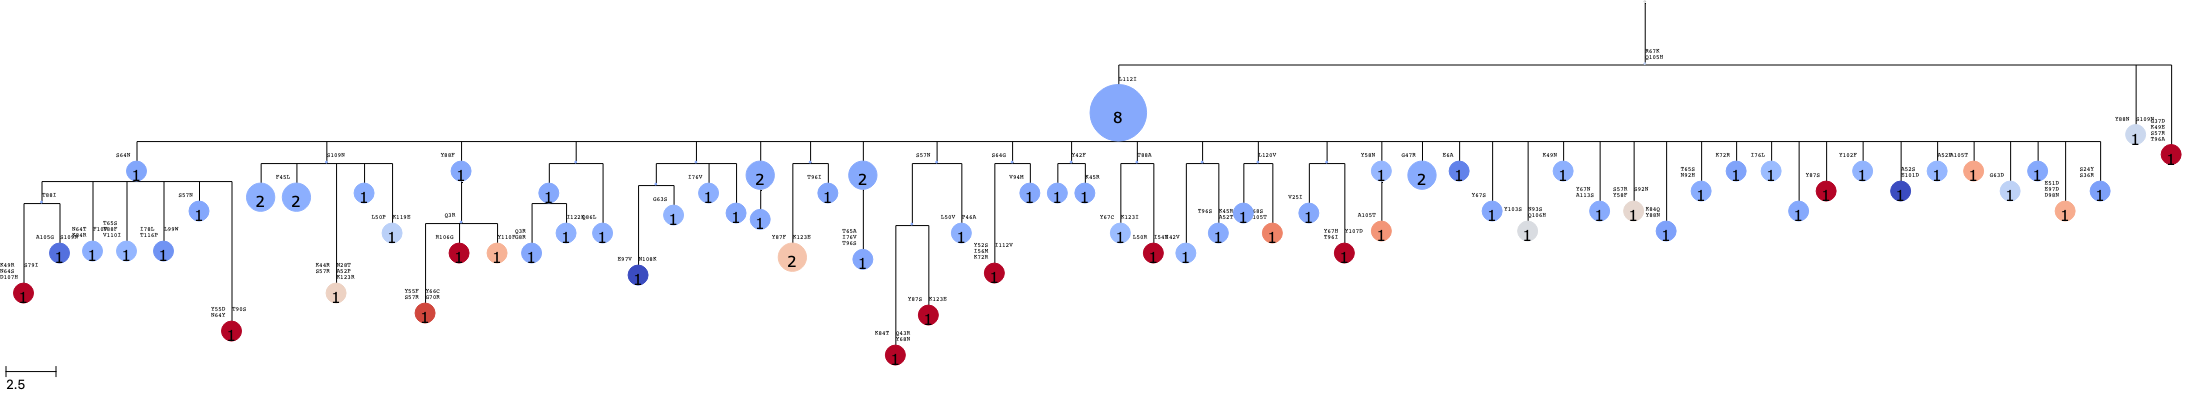

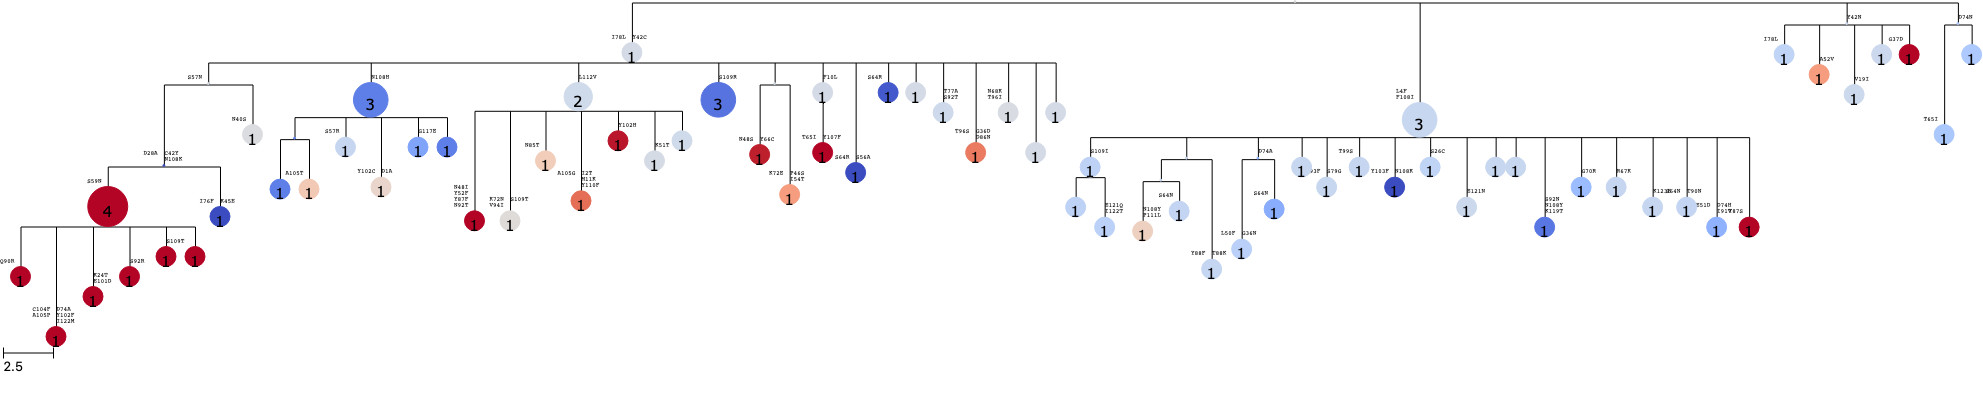

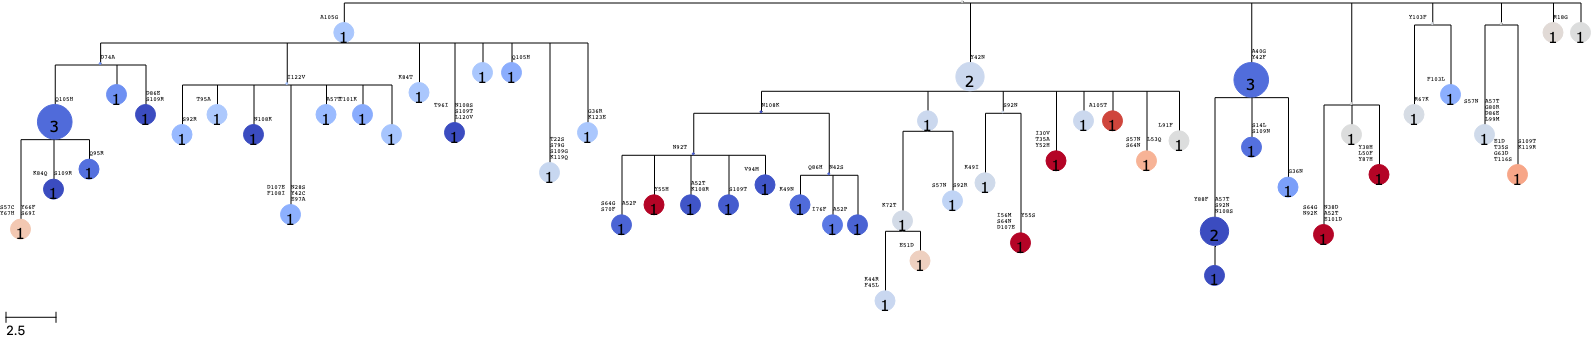

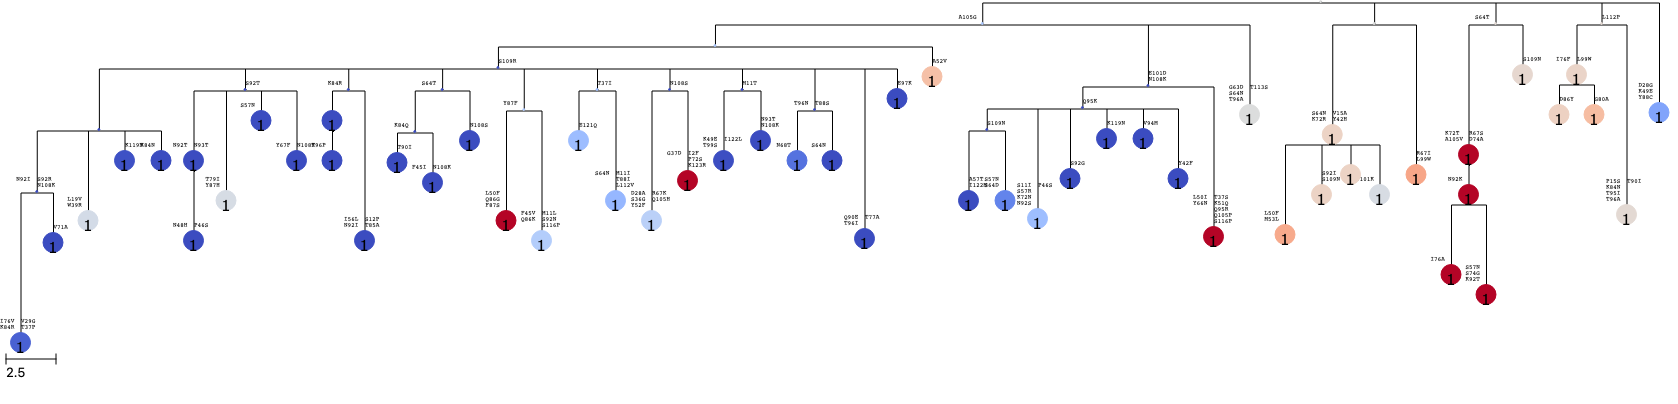

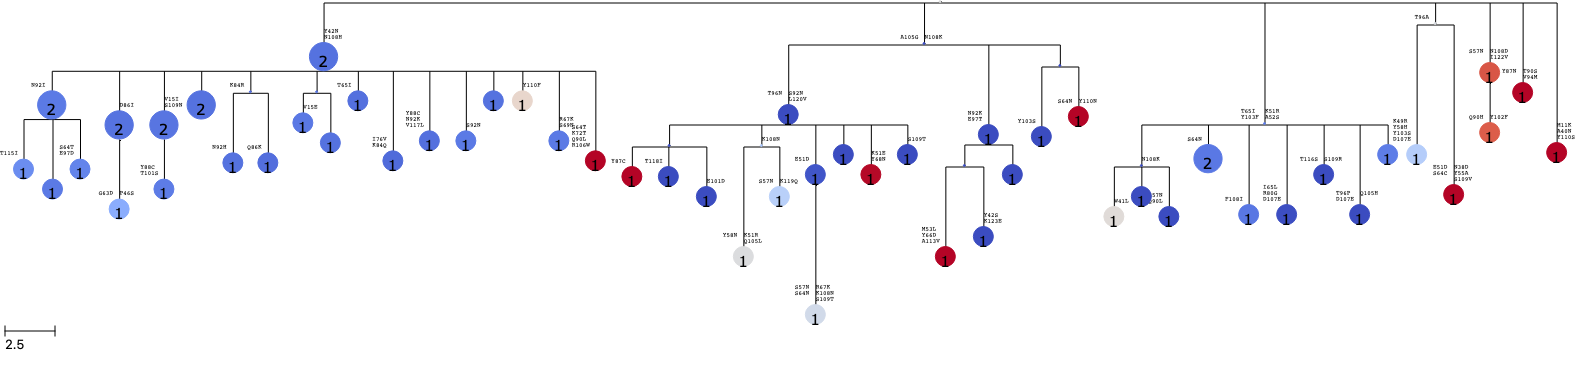

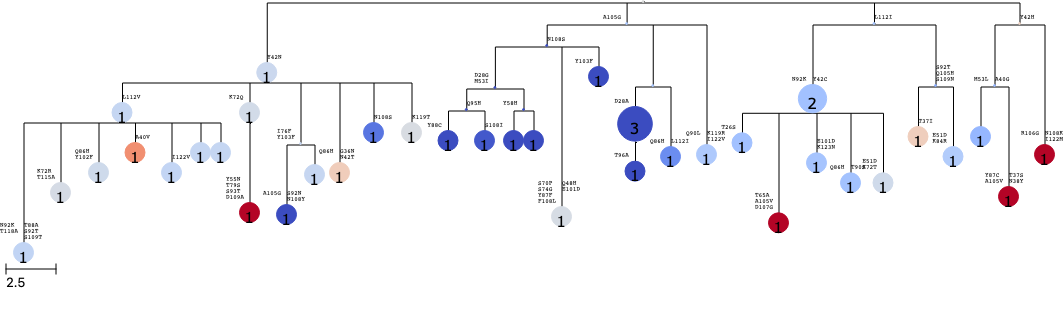

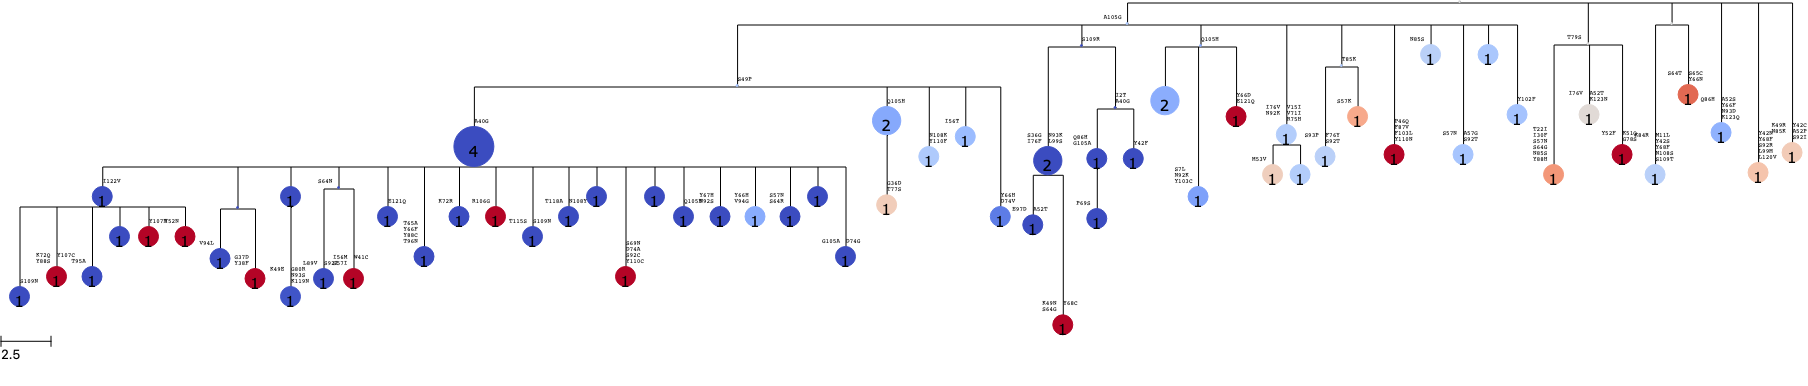

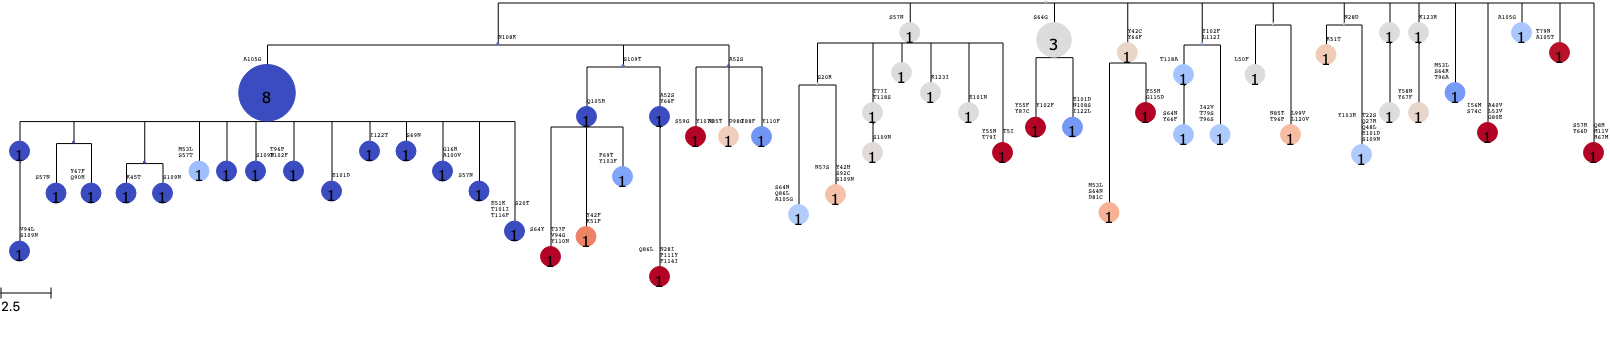

In [160]:
for tree in trees:
    display(tree.render("%%inline", scale=20,
                        colormap=bind_colormap(tree, vmin, vmax),
                        frame=igh_frame, frame2=igk_frame, chain_split=igk_idx,
                        position_map=igh_pos_map.site, position_map2=igk_pos_map.site))

# Distributions of affinity effects of mutations on trees

Let's look at phenotypic effects of *sitewise* first-step mutations. We can do this sitewise because we are using an additive model. This would also work with a global epistasis model, with an additive latent space.

In [111]:
def hit_counts(tree):
    node_generator = tree.tree.traverse()
    root = next(node)
    root.add_feature("hit counts", [0] * len(naive_igh_aa))
        naive_igh_aa = aa(tree.tree.sequence[:igk_idx], igh_frame)
    naive_igk_aa = aa(tree.tree.sequence[igk_idx:], igk_frame)
    for node in node_generator:
        igh_aa = aa(node.sequence[:igk_idx], igh_frame)
        igk_aa = aa(node.sequence[igk_idx:], igk_frame)

IndentationError: unexpected indent (427562999.py, line 5)

In [110]:
next(tree.tree.traverse())

Tree node 'naive' (0x13d135be)

In [101]:
def mutation_effects(node):
    if node.up is None:
        return []
    naive_igh_aa = aa(tree.tree.sequence[:igk_idx], igh_frame)
    naive_igk_aa = aa(tree.tree.sequence[igk_idx:], igk_frame)
    parent_igh_aa = aa(node.up.sequence[:igk_idx], igh_frame)
    parent_igk_aa = aa(node.up.sequence[igk_idx:], igk_frame)
    parent_igh_mutations = mutations(naive_igh_aa, parent_igh_aa, igh_pos_map.site, "(H)")
    parent_igk_mutations = mutations(naive_igk_aa, parent_igk_aa, igk_pos_map.site, "(L)")
    parent_mutations = parent_igh_mutations + parent_igk_mutations
    
    igh_aa = aa(node.sequence[:igk_idx], igh_frame)
    igk_aa = aa(node.sequence[igk_idx:], igk_frame)
    igh_mutations = mutations(parent_igh_aa, igh_aa, igh_pos_map.site, "(H)")
    igk_mutations = mutations(parent_igk_aa, igk_aa, igk_pos_map.site, "(L)")
    node_mutations = igh_mutations + igk_mutations

    for mutation in node_mutations:
        match = [parent_mutation for parent_mutation in parent_mutations if parent_mutation[1:] == mutation[1:]]
#         dms_df.mutation[dms_df.mutation.str[1:] == mutation[1:]]
        assert len(match) < 2
        print(match)
        if len(match) = 0:
            effect = dms_df.delta_bind[dms_df.mutation == mutation].iloc[0]
            print(effect)
        else:
            print
#         print(mutation)
#         print(match)
    
#     print(parent_igh_mutations + parent_igk_mutations)
#     print(igh_mutations + igk_mutations)
    
#     sum_delta_bind = dms_df.delta_bind[dms_df.mutation.isin(igh_mutations + igk_mutations)].sum()
    
    return 

In [102]:
for node in tree.tree.traverse():
    mutation_effects(node)

[]
-0.59898
[]
-4.04435
[]
0.03567
[]
-0.00503
[]
-0.01478
[]
0.00263
[]
-0.97242
[]
0.331
[]
-0.0086
[]
-0.04838
[]
-0.71399
[]
-0.04485
[]
-0.78621
[]
-0.27104
[]
0.86927
[]
0.02534
[]
-0.00335
[]
-0.15612
[]
0.03371
[]
0.34886
[]
-0.01042
[]
-0.09461
[]
-0.00685
[]
-0.01297
[]
0.86582
[]
-0.0881
[]
0.00551
[]
0.17986
[]
0.01564
[]
0.33206
[]
0.0188
[]
-0.05815
[]
-0.03494
[]
-0.03946
[]
-0.2854
[]
0.02465
[]
-0.04138
[]
0.005
[]
-0.00937
[]
-0.07037
[]
-0.00244
[]
-0.00153
[]
-0.017
[]
-2.98491
[]
-0.57422
[]
-0.27104
[]
0.02258
[]
-0.01913
[]
-0.05815
[]
0.68393
[]
0.01511
[]
-0.20324
[]
-2.60423
[]
0.03371
[]
-3.6806
[]
0.03003
[]
0.02323
[]
0.01201
[]
0.0172
[]
0.04376
[]
-0.03233
[]
-0.02832
[]
0.70794
[]
-0.01932
[]
0.331
[]
0.02258
[]
-0.02677
[]
-0.03494
[]


IndexError: single positional indexer is out-of-bounds

In [130]:
from collections import Counter
Counter(Counter(dms_df.mutation).values())

Counter({1: 4400, 10: 20, 3: 20, 4: 20})

In [190]:
bind_colormap(trees[0], vmin, vmax)

NameError: name 'trees' is not defined